# Description

# Imports

In [1]:
import os, json, time, sys
from wildfire.Reader import Reader
import geojson
import requests
import pyproj
import math
import numpy as np
import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pyproj import Transformer, Geod
from wildfire.Reader import Reader as WFReader
from tqdm import tqdm
import sklearn
import matplotlib.pyplot as plt
#from apikeys.Manager import Manager

# Load GEOJSON file reader

In [5]:
data_filepath = "./../Data/GeoJson_Exports/USGS_Wildland_Fire_Combined_Dataset.json"
print(f"Attempting to open '{data_filepath}'")
geojson_file = open(data_filepath,"r")
print(f"Using GeoJSON module to load sample file '{data_filepath}'")
gj_data = geojson.load(geojson_file)
geojson_file.close()
wfreader = WFReader(data_filepath)

Attempting to open './../Data/GeoJson_Exports/USGS_Wildland_Fire_Combined_Dataset.json'
Using GeoJSON module to load sample file './../Data/GeoJson_Exports/USGS_Wildland_Fire_Combined_Dataset.json'


# Get fire data into list of json objects

In [6]:
MAX_FEATURE_LOAD = 999999999
feature_list = list()
feature_count = 0
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result 
wfreader.rewind()
# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature_count += 1
    # if we're loading a lot of features, print progress
    if (feature_count % 10000) == 0:
        print(f"Loaded {feature_count} features")
    # loaded the max we're allowed then break
    if feature_count >= MAX_FEATURE_LOAD:
        break
    feature = wfreader.next()
    
# print the number of items (features) we think we loaded
print(f"Loaded a total of {feature_count} features")

Loaded 10000 features
Loaded 20000 features
Loaded 30000 features
Loaded 40000 features
Loaded 50000 features
Loaded 60000 features
Loaded 70000 features
Loaded 80000 features
Loaded 90000 features
Loaded 100000 features
Loaded 110000 features
Loaded 120000 features
Loaded 130000 features
Loaded a total of 135061 features


# For each fire calculate average ring distance from Leavenworth Kansas

In [20]:
CITY_COORDS = (39.313015, -94.941147) #LAT, LON in EPSG:4326/WSG84

#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average

def calculate_fire_distances(geojson_data, coords):
    for i in tqdm(range(len(geojson_data)), position=0, leave=True):
        try:
            wf_feature = geojson_data[i]
            wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
            wf_year = wf_feature['attributes']['Fire_Year']
            ring_data = wf_feature['geometry']['rings'][0]
            wf_size = wf_feature['attributes']['GIS_Acres']
            wf_type = wf_feature['attributes']['Assigned_Fire_Type']
            distance = average_distance_from_place_to_fire_perimeter(coords, ring_data)
            wf_feature['distance_from_Leavenworth'] = distance
        except:
            print("Could not calculate distance for", wf_feature['attributes']['Listed_Fire_Names'].split(',')[0])

calculate_fire_distances(feature_list, CITY_COORDS)

 81%|████████████████████████████████████████████████████████▊             | 109606/135061 [2:58:15<35:37, 11.91it/s]

Could not calculate distance for BARNES SOUTH UNDERBURN - BARNES SOUTH  UNDERBURN (1)


 82%|█████████████████████████████████████████████████████████▏            | 110225/135061 [2:59:17<34:43, 11.92it/s]

Could not calculate distance for BOYD JOHNSON (1)


 82%|█████████████████████████████████████████████████████████▎            | 110640/135061 [2:59:58<33:44, 12.06it/s]

Could not calculate distance for VIRGINIAS (3)


 83%|█████████████████████████████████████████████████████████▊            | 111433/135061 [3:01:14<32:35, 12.09it/s]

Could not calculate distance for GEORGE BRAND (1)


 83%|█████████████████████████████████████████████████████████▉            | 111777/135061 [3:01:47<33:52, 11.46it/s]

Could not calculate distance for HOMOCHITTO BURN BLOCK 36 (1)


 83%|█████████████████████████████████████████████████████████▉            | 111898/135061 [3:01:59<32:53, 11.74it/s]

Could not calculate distance for VIRGINIAS (2)


 83%|██████████████████████████████████████████████████████████▎           | 112412/135061 [3:02:49<33:34, 11.25it/s]

Could not calculate distance for JAMIE JORDON (1)


 83%|██████████████████████████████████████████████████████████▎           | 112418/135061 [3:02:50<31:56, 11.81it/s]

Could not calculate distance for JIM TIMBERLAKE (1)


 84%|██████████████████████████████████████████████████████████▊           | 113412/135061 [3:04:26<30:15, 11.93it/s]

Could not calculate distance for No Fire Name Provided (1)


 84%|██████████████████████████████████████████████████████████▉           | 113668/135061 [3:04:51<30:33, 11.67it/s]

Could not calculate distance for WILLIAM GHOLSTON (1)


 84%|██████████████████████████████████████████████████████████▉           | 113739/135061 [3:04:57<29:21, 12.10it/s]

Could not calculate distance for JOHN HUTCHESON (1)


 84%|██████████████████████████████████████████████████████████▉           | 113768/135061 [3:05:00<29:16, 12.12it/s]

Could not calculate distance for JEAN DODSON (1)


 84%|██████████████████████████████████████████████████████████▉           | 113807/135061 [3:05:04<29:29, 12.01it/s]

Could not calculate distance for KEITH O'DANIEL (1)


 85%|███████████████████████████████████████████████████████████▏          | 114311/135061 [3:05:52<28:14, 12.25it/s]

Could not calculate distance for MICHAEL CROWE (1)


 85%|███████████████████████████████████████████████████████████▎          | 114324/135061 [3:05:53<28:21, 12.18it/s]

Could not calculate distance for JEANETTE WALKER (1)


 86%|███████████████████████████████████████████████████████████▉          | 115630/135061 [3:07:59<27:26, 11.80it/s]

Could not calculate distance for No Fire Name Provided (2)


 86%|████████████████████████████████████████████████████████████          | 115976/135061 [3:08:33<26:44, 11.90it/s]

Could not calculate distance for No Fire Name Provided (1)


 86%|████████████████████████████████████████████████████████████▏         | 116237/135061 [3:08:58<26:01, 12.05it/s]

Could not calculate distance for Little Bald Hills - Williams Ridge Rx (2)


 87%|████████████████████████████████████████████████████████████▋         | 117088/135061 [3:10:21<25:08, 11.92it/s]

Could not calculate distance for BALANCE UNDERBURN UNIT 2-1 (1)


 89%|█████████████████████████████████████████████████████████████▉        | 119583/135061 [3:14:25<21:49, 11.82it/s]

Could not calculate distance for MYRTLE BB WUI FY 15 (1)


 89%|█████████████████████████████████████████████████████████████▉        | 119620/135061 [3:14:29<22:54, 11.23it/s]

Could not calculate distance for RICHARDS


 89%|██████████████████████████████████████████████████████████████        | 119752/135061 [3:14:42<21:34, 11.83it/s]

Could not calculate distance for DELTA BLOCK 1 (1)


 89%|██████████████████████████████████████████████████████████████▏       | 119985/135061 [3:15:05<22:38, 11.10it/s]

Could not calculate distance for JIM BETHEL GFC (1)


 89%|██████████████████████████████████████████████████████████████▎       | 120214/135061 [3:15:27<21:06, 11.72it/s]

Could not calculate distance for INTERDISCIPLINARY UNIT LBJ 41 - PATCH BURN UNIT A (HOPWELL CHURCH) (1)


 89%|██████████████████████████████████████████████████████████████▍       | 120432/135061 [3:15:49<19:36, 12.43it/s]

Could not calculate distance for 2_HL_MRA Administrative Tumbleweeds 5 (1)


 89%|██████████████████████████████████████████████████████████████▌       | 120679/135061 [3:16:15<20:00, 11.98it/s]

Could not calculate distance for FULTON (1)


 89%|██████████████████████████████████████████████████████████████▌       | 120744/135061 [3:16:22<19:18, 12.36it/s]

Could not calculate distance for MYRTLE BB FY 17 (1)


 90%|██████████████████████████████████████████████████████████████▋       | 121011/135061 [3:16:49<19:40, 11.90it/s]

Could not calculate distance for No Fire Name Provided (1)


 91%|███████████████████████████████████████████████████████████████▎      | 122265/135061 [3:18:54<19:01, 11.21it/s]

Could not calculate distance for LITTLE SPRINGS - LITTLE SPRINGS  BROADCAST BURN (1)


 91%|███████████████████████████████████████████████████████████████▌      | 122533/135061 [3:19:21<17:26, 11.97it/s]

Could not calculate distance for FACILITIES - EBP (1)


 92%|████████████████████████████████████████████████████████████████▏     | 123764/135061 [3:21:23<16:36, 11.34it/s]

Could not calculate distance for Wapato Irrigation Project - 18 WIP Ditch Burn (1)


 92%|████████████████████████████████████████████████████████████████▌     | 124536/135061 [3:22:43<14:34, 12.04it/s]

Could not calculate distance for NORTH DIVIDE UNIT 10 - NORTH DIVIDE UB UNIT 10A (1)


 93%|████████████████████████████████████████████████████████████████▊     | 125047/135061 [3:23:36<13:38, 12.23it/s]

Could not calculate distance for GREYS MOUNTAIN - GREYS U16 (1)


 93%|█████████████████████████████████████████████████████████████████▏    | 125746/135061 [3:24:52<12:38, 12.28it/s]

Could not calculate distance for BJUGSTAD/OWEGO ANNEX - BJUGSTAD WEST SPRING BURN 2019 (1)


 94%|██████████████████████████████████████████████████████████████████    | 127493/135061 [3:28:00<10:30, 12.00it/s]

Could not calculate distance for NORTH DIVIDE UNIT 12 (2)


100%|██████████████████████████████████████████████████████████████████████| 135061/135061 [3:41:04<00:00, 10.18it/s]


In [26]:
#Save these distances to a new file so we don't have to redo the calculations (They take a long time)
#print(feature_list[0])
with open('./../Data/USGS_Wildland_Fire_Combined_WithDistances.json', 'w') as f:
    json.dump({"data": feature_list}, f)

In [2]:
# Read in file, and clear out old information to save on space
feature_list = 0
gj_data = 0
with open('./../Data/USGS_Wildland_Fire_Combined_WithDistances.json') as f:
    wildfire_data = json.load(f)["data"]

In [3]:
def get_fires_in_distance(geojson_data, miles):
    fires_in_distance = []
    for i in range(len(geojson_data)):
        try:
            wf_feature = geojson_data[i]
            wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
            wf_year = wf_feature['attributes']['Fire_Year']
            ring_data = wf_feature['geometry']['rings'][0]
            wf_size = wf_feature['attributes']['GIS_Acres']
            wf_type = wf_feature['attributes']['Assigned_Fire_Type']
            distance = wf_feature['distance_from_Leavenworth']
            #print(distance)
            if(distance <= 1250):
                fires_in_distance.append(wf_feature)
                #print(wf_name, distance)
        except:
            print("No data for", wf_feature['attributes']['Listed_Fire_Names'].split(',')[0])
    return fires_in_distance

city_fires = get_fires_in_distance(wildfire_data, 1250)
print("There are a total of", len(city_fires), "within 1250 miles of leavenworth, kansas",)

No data for BARNES SOUTH UNDERBURN - BARNES SOUTH  UNDERBURN (1)
No data for BOYD JOHNSON (1)
No data for VIRGINIAS (3)
No data for GEORGE BRAND (1)
No data for HOMOCHITTO BURN BLOCK 36 (1)
No data for VIRGINIAS (2)
No data for JAMIE JORDON (1)
No data for JIM TIMBERLAKE (1)
No data for No Fire Name Provided (1)
No data for WILLIAM GHOLSTON (1)
No data for JOHN HUTCHESON (1)
No data for JEAN DODSON (1)
No data for KEITH O'DANIEL (1)
No data for MICHAEL CROWE (1)
No data for JEANETTE WALKER (1)
No data for No Fire Name Provided (2)
No data for No Fire Name Provided (1)
No data for Little Bald Hills - Williams Ridge Rx (2)
No data for BALANCE UNDERBURN UNIT 2-1 (1)
No data for MYRTLE BB WUI FY 15 (1)
No data for RICHARDS
No data for DELTA BLOCK 1 (1)
No data for JIM BETHEL GFC (1)
No data for INTERDISCIPLINARY UNIT LBJ 41 - PATCH BURN UNIT A (HOPWELL CHURCH) (1)
No data for 2_HL_MRA Administrative Tumbleweeds 5 (1)
No data for FULTON (1)
No data for MYRTLE BB FY 17 (1)
No data for No Fir

# Show example data

In [4]:
print(json.dumps(wildfire_data[0],indent=2))

{
  "attributes": {
    "OBJECTID": 1,
    "USGS_Assigned_ID": 1,
    "Assigned_Fire_Type": "Wildfire",
    "Fire_Year": 1860,
    "Fire_Polygon_Tier": 1,
    "Fire_Attribute_Tiers": "1 (1)",
    "GIS_Acres": 3940.20708940724,
    "GIS_Hectares": 1594.5452365353703,
    "Source_Datasets": "Comb_National_NIFC_Interagency_Fire_Perimeter_History (1)",
    "Listed_Fire_Types": "Wildfire (1)",
    "Listed_Fire_Names": "Big Quilcene River (1)",
    "Listed_Fire_Codes": "No code provided (1)",
    "Listed_Fire_IDs": "",
    "Listed_Fire_IRWIN_IDs": "",
    "Listed_Fire_Dates": "Listed Other Fire Date(s): 2006-11-02 - NIFC DATE_CUR field (1)",
    "Listed_Fire_Causes": "",
    "Listed_Fire_Cause_Class": "Undetermined (1)",
    "Listed_Rx_Reported_Acres": null,
    "Listed_Map_Digitize_Methods": "Other (1)",
    "Listed_Notes": "",
    "Processing_Notes": "",
    "Wildfire_Notice": "Wildfire mapping prior to 1984 was inconsistent, infrequent, and done without the aid of more modern fire mapping

# Put fires into dictionary grouped by "Fire_Year"

In [5]:
fires_grouped_by_year = {}
for fire in wildfire_data:
    year = str(fire["attributes"]["Fire_Year"])
    if(year not in fires_grouped_by_year.keys()):
        fires_grouped_by_year[year] = []
        fires_grouped_by_year[year].append(fire)
    else:
        fires_grouped_by_year[year].append(fire)

# Estimate annual smoke estimate
Smoke production of wood is 25-100 m^2/kg http://virtual.vtt.fi/virtual/innofirewood/stateoftheart/database/burning/burning.html#:~:text=In%20well%20ventilated%20conditions%2C%20the,the%20smoke%20production%20of%20wood. 



In [6]:
annual_smoke_estimates = {}
start_year = 1963
end_year = 2023

for year in range(1963, 2023):
    total_smoke_volume_estimate = 0
    if(str(year) not in fires_grouped_by_year.keys()):
        annual_smoke_estimates[str(year)] = {"total_smoke_volume_estimate": 0}
        continue
    for fire in fires_grouped_by_year[str(year)]:
        try:
            area_of_forest_burned = fire["attributes"]["Shape_Area"] #Square meters
            distance_from_leavenworth = fire["distance_from_Leavenworth"]
            if(distance_from_leavenworth > 1250):
                continue
        
            #Making bad assumption that there is 10kg of wood on average per square meter in a forest
            wood_burned_estimate = area_of_forest_burned * 10 #In Kilograms
            
            #Assumption from source above to calculate smoke volume from burning wood
            smoke_volume_estimate = wood_burned_estimate * 87.5 #Meters squared
        
            #Making bad assumption that smoke dispersion is inversely proportion to the exponential of distance
            smoke_volume_estimate = smoke_volume_estimate / (int(distance_from_leavenworth)**5)
            total_smoke_volume_estimate += smoke_volume_estimate
            annual_smoke_estimates[str(year)] = {
                "total_smoke_volume_estimate": total_smoke_volume_estimate
            }
        except:
            print("Skipped over", fire['attributes']['Listed_Fire_Names'].split(',')[0])

print(annual_smoke_estimates)
# Summation
# Volume of wood burned * volume of smoke produced by burning X volume of wood
# / distance from city
# Divide by N
# Divide by max
# Multiply by 500

Skipped over BARNES SOUTH UNDERBURN - BARNES SOUTH  UNDERBURN (1)
Skipped over BOYD JOHNSON (1)
Skipped over VIRGINIAS (3)
Skipped over GEORGE BRAND (1)
Skipped over HOMOCHITTO BURN BLOCK 36 (1)
Skipped over VIRGINIAS (2)
Skipped over JAMIE JORDON (1)
Skipped over JIM TIMBERLAKE (1)
Skipped over No Fire Name Provided (1)
Skipped over WILLIAM GHOLSTON (1)
Skipped over JOHN HUTCHESON (1)
Skipped over JEAN DODSON (1)
Skipped over KEITH O'DANIEL (1)
Skipped over MICHAEL CROWE (1)
Skipped over JEANETTE WALKER (1)
Skipped over No Fire Name Provided (2)
Skipped over No Fire Name Provided (1)
Skipped over Little Bald Hills - Williams Ridge Rx (2)
Skipped over BALANCE UNDERBURN UNIT 2-1 (1)
Skipped over MYRTLE BB WUI FY 15 (1)
Skipped over RICHARDS
Skipped over DELTA BLOCK 1 (1)
Skipped over JIM BETHEL GFC (1)
Skipped over INTERDISCIPLINARY UNIT LBJ 41 - PATCH BURN UNIT A (HOPWELL CHURCH) (1)
Skipped over 2_HL_MRA Administrative Tumbleweeds 5 (1)
Skipped over FULTON (1)
Skipped over MYRTLE BB F

# Compare estimate to AQI
AQI ranges from 0-500+, where 500+ is called 'beyond the AQI' and is extremely hazardous

#### Constants

In [156]:
USERNAME = "zbowyer@uw.edu"
APIKEY = "tealmallard53"  #I know this is bad but there's nothing at stake here

#Request API Key
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'
API_ACTION_SIGNUP = '/signup?email=zbowyer@uw.edu'
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

CITY_LOCATIONS = {
    'Leavenworth' :    {'city'   : 'Leavenworth',
                       'county' : 'Leavenworth',
                       'state'  : 'Kansas',
                       'fips'   : '20103',
                       'latlon' : [39.313015, -94.941147]},
}

EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

#### Functions

In [157]:
##################################################
##################################################
##################################################
##################################################
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")
    
    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

#print("Requesting SIGNUP ...")
#response = request_signup("zbowyer@uw.edu")
#print(json.dumps(response,indent=4))

##################################################
##################################################
##################################################
##################################################
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

##################################################
##################################################
##################################################
##################################################
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

##################################################
##################################################
##################################################
##################################################
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format

        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result

##################################################
##################################################
##################################################
##################################################
#   Compute a rough estimates for a bounding box around a given place
#   The bounding box is scaled in 50 mile increments. That is the bounding box will have sides that
#   are rough multiples of 50 miles, with the center of the box around the indicated place.
#   The scale parameter determines the scale (size) of the bounding box
#
def bounding_latlon(place=None,scale=1.0):
    LAT_25MILES = 25.0 * (1.0/69.0)    # This is about 25 miles of latitude in decimal degrees
    LON_25MILES = 25.0 * (1.0/54.6)    # This is about 25 miles of longitude in decimal degrees
    minlat = place['latlon'][0] - float(scale) * LAT_25MILES
    maxlat = place['latlon'][0] + float(scale) * LAT_25MILES
    minlon = place['latlon'][1] - float(scale) * LON_25MILES
    maxlon = place['latlon'][1] + float(scale) * LON_25MILES
    return [minlat,maxlat,minlon,maxlon]

#### List of all monitoring stations in leavenworth county
As you can see, there are some stations in leavenworth

In [113]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['Leavenworth']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['Leavenworth']['fips'][2:]  # the last three digits (characters) of FIPS is the county code
response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)
print(response)

{'Header': [{'status': 'Success', 'request_time': '2023-11-05T00:57:01-04:00', 'url': 'https://aqs.epa.gov/data/api/list/sitesByCounty?email=zbowyer@uw.edu&key=tealmallard53&state=20&county=103', 'rows': 5}], 'Data': [{'code': '0001', 'value_represented': None}, {'code': '0002', 'value_represented': None}, {'code': '0003', 'value_represented': 'Leavenworth'}, {'code': '0004', 'value_represented': 'SPORTSMAN FIELD'}, {'code': '1001', 'value_represented': None}]}


#### Example of monthly summary
However they dont give particulate data, which is what we want

In [135]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['Leavenworth']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['Leavenworth']['fips'][2:]

# request daily summary data for the month of July in 2021
request_data['param'] = AQI_PARAMS_PARTICULATES
particulate_aqi = request_daily_summary(request_template=request_data, begin_date="20190701", end_date="20190731")
if particulate_aqi["Header"][0]['status'].startswith("No data "):
    print("Looks like the response generated no data for particulates. You might take a closer look at your request and the response data.")

extract_particulate = extract_summary_from_response(particulate_aqi)
print("Summary of particulate extraction ...")
print(json.dumps(extract_particulate,indent=4))

Looks like the response generated no data for particulates. You might take a closer look at your request and the response data.
Summary of particulate extraction ...
{}


#### Get AQI of particulate via bounding box to find closest station

In [181]:
def get_AQI_estimate_for_month(begin_date, end_date):
    request_data = AQS_REQUEST_TEMPLATE.copy()
    request_data['email'] = USERNAME
    request_data['key'] = APIKEY
    bbox = bounding_latlon(CITY_LOCATIONS['Leavenworth'],scale=10.0)
    request_data['minlat'] = bbox[0]
    request_data['maxlat'] = bbox[1]
    request_data['minlon'] = bbox[2]
    request_data['maxlon'] = bbox[3]

    # request daily summary data for the month of July in 2021
    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date, endpoint_action = API_ACTION_DAILY_SUMMARY_BOX)
    #print(particulate_aqi)
    #if particulate_aqi["Header"][0]['status'].startswith("No data "):
    #    print("Looks like the response generated no data for particulates. You might take a closer look at your request and the response data.")
    
    extract_particulate = extract_summary_from_response(particulate_aqi)
        #return -1
    #print(json.dumps(extract_particulate,indent=4))
    
    largest_aqi_monthly_estimate = 0 
    for key in extract_particulate.keys():
        station = extract_particulate[key]
        station_state = station["state"]
        station_county = station["county"]
        station_city = station["city"]
        #For each day, get 24-HR BLK AVG of 81102 and 88101 and avg their aqi
        
        reported_avg_monthly_81102 = 0
        reported_avg_monthly_88101 = 0 
        estimated_avg_pp = 0
        
        #For each day, get 24hr of 81102 (PM10 Total 0-10um STP)
        if("81102" in station["pollutant_type"].keys()):
            counter = 0
            for key in station["pollutant_type"]["81102"]["data"].keys():
                day = station["pollutant_type"]["81102"]["data"][key]
                for i in range(len(day)):
                    if(day[i]["sample_duration"] == "24-HR BLK AVG"):
                        aqi = day[i]['aqi']
                        reported_avg_monthly_81102 += aqi
                        counter += 1
            if(counter != 0):
                reported_avg_monthly_81102 /= counter
        
        #For each day, get 24hr of 81102 (PM10 Total 0-10um STP)
        if("88101" in station["pollutant_type"].keys()):
            counter = 0
            for key in station["pollutant_type"]["88101"]["data"].keys():
                day = station["pollutant_type"]["88101"]["data"][key]
                for i in range(len(day)):
                    if(day[i]["sample_duration"] == "24-HR BLK AVG"):
                        aqi = day[i]['aqi']
                        reported_avg_monthly_88101 += aqi
                        counter += 1
            if(counter != 0):
                reported_avg_monthly_88101 /= counter
    
        estimated_avg_pp = (reported_avg_monthly_81102 + reported_avg_monthly_88101) / 2
        
        if(estimated_avg_pp) > largest_aqi_monthly_estimate:
            largest_aqi_monthly_estimate = estimated_avg_pp
    return largest_aqi_monthly_estimate

aqi_est = get_AQI_estimate_for_month("20210201", "20210128")
print("AQI estimate")
print(aqi_est)

AQI estimate
0


In [319]:
#Get all monthly AQI estimates from 1963 - 2023 for Leavenworth
aqi_estimates = {}
month_strs = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
for year in range(1963,2023):
    for month in month_strs:
        end_day = "31"
        if(month == "02"):
            end_day = "28"
        if(month == "04" or month == "06" or month == "09" or month == "11"):
            end_day = "30"
        begin_date_str = str(year) + month + "01"
        end_date_str = str(year) + month + end_day
        aqi_est = get_AQI_estimate_for_month(begin_date_str, end_date_str)
        #print(begin_date_str, end_date_str, aqi_est)
        aqi_estimates[begin_date_str] = aqi_est

# Predictive model based on fire data and smoke estimate, forecast to 2049

In [132]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm

#If you have the extra data do a linear regression
#Else do an ARMA

#Get data into dataframe
dates = []
distances = []
acres = []
smoke_estimates = []
for year in annual_smoke_estimates.keys():
    dates.append(str(year) + "-1-1")
    total_acres = 0
    total_distance = 0
    if(str(year) in fires_grouped_by_year.keys()):
        for fire in fires_grouped_by_year[str(year)]:
            if('distance_from_Leavenworth') not in fire.keys():
                continue
            GIS_Acres = fire['attributes']['GIS_Acres']
            distance = fire['distance_from_Leavenworth']
            total_acres += GIS_Acres
            total_distance += distance
    distances.append(total_distance)
    acres.append(total_acres)
    smoke_estimates.append(annual_smoke_estimates[year]['total_smoke_volume_estimate'])

dates = np.array(dates)
distances = np.array(distances)
acres = np.array(acres)
smoke_estimates = np.array(smoke_estimates)
combined_data_numpy = (np.dstack([dates, distances, acres, smoke_estimates]))
df = pd.DataFrame(data = combined_data_numpy[0], columns = ['date', 'sum_distance', 'sum_acres', 'smoke_est'])
df.head()

#Linear regression
print("Linear regression predictions for when we do have data: ")
x = df[['sum_distance', 'sum_acres']]
y = df[['smoke_est']]
#x = sm.add_constant(x)
model = sm.OLS(y.astype(float), x.astype(float)).fit()
predictions = model.predict(x.astype(float)) 
print(model.summary())

year = 1963
for i in range(len(predictions)):
    print("Year:", year, "Real:", smoke_estimates[i], "Predicted:", predictions[i])
    year += 1
#print(predictions, smoke_estimates)

#Forecast using ARIMA
print("Smoke estimate forecasting: ")
model = statsmodels.tsa.arima.model.ARIMA(y.astype(float), order=(4,0,0)).fit()
predictions = model.predict(start=60, end=86)
print(model.summary())
for pred in predictions:
    print("Year:", year, "Predicted:", pred)
    year += 1

Linear regression predictions for when we do have data: 
                                 OLS Regression Results                                
Dep. Variable:              smoke_est   R-squared (uncentered):                   0.380
Model:                            OLS   Adj. R-squared (uncentered):              0.359
Method:                 Least Squares   F-statistic:                              17.79
Date:                Sun, 05 Nov 2023   Prob (F-statistic):                    9.42e-07
Time:                        15:59:52   Log-Likelihood:                         -381.89
No. Observations:                  60   AIC:                                      767.8
Df Residuals:                      58   BIC:                                      772.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [

# Visualization 1: Histogram showing number of fires occuring every 50 mile distance up to the max specified distance

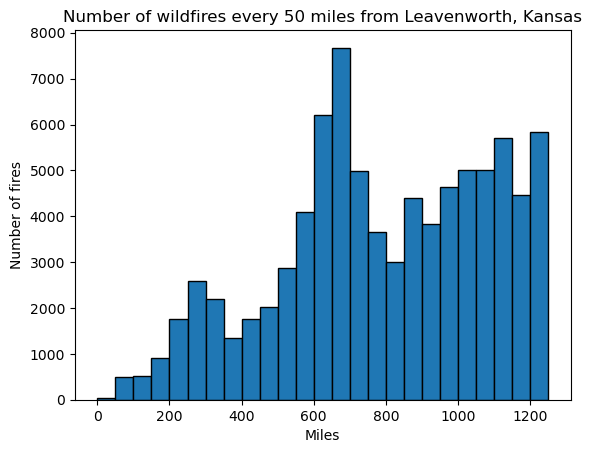

In [245]:
def histogram_number_fires(max_dist):
    distances = []
    for fire in wildfire_data:
        try:
            distance = fire["distance_from_Leavenworth"]
        except:
            continue
        if(distance < max_dist):
            distances.append(distance)

    bins = np.linspace(0, max_dist, ((max_dist) // 50)+1)
    plt.hist(distances, bins, edgecolor='black')
    plt.xlabel("Miles")
    plt.ylabel("Number of fires")
    plt.title("Number of wildfires every 50 miles from Leavenworth, Kansas")

histogram_number_fires(1250)


# Visualization 2: Time series graph of total acres burned per year for the fires occuring in the specified distance from Leavenworth

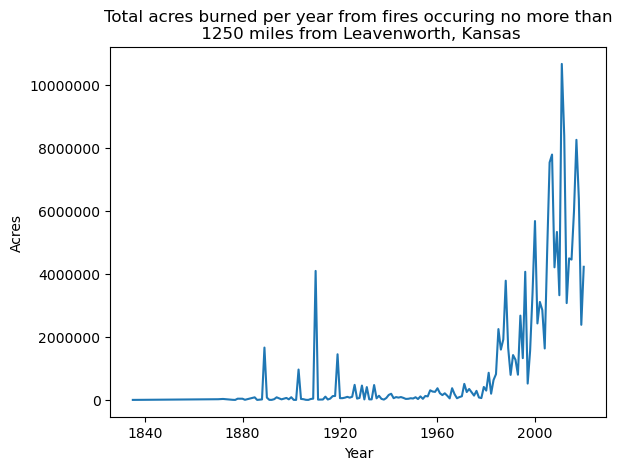

In [297]:
def time_series_totalacres(max_distance):
    dates = []
    acres_burned = []
    years = []
    for year in fires_grouped_by_year:
        years.append(year)
    years.sort()
    
    for year in years:
        fires = fires_grouped_by_year[year]
        dates.append("01/01/"+ str(year))
        total_acres_burned = 0
        for fire in fires:
            if("distance_from_Leavenworth" in fire.keys()):
                distance = fire["distance_from_Leavenworth"]
                if(distance < max_distance):
                    total_acres_burned += fire["attributes"]["GIS_Acres"]
        acres_burned.append(total_acres_burned)
    dates = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
    plt.plot(dates, acres_burned)
    plt.ticklabel_format(style='plain', useOffset=False, axis='y')
    plt.xlabel("Year")
    plt.ylabel("Acres")
    plt.title("Total acres burned per year from fires occuring no more than\n " + str(max_distance) + " miles from Leavenworth, Kansas")
time_series_totalacres(1250)

# Visualization 3: Time series graph containing fire smoke estimate and AQI estimate for Leavenworth

Text(0.5, 1.0, 'Time series of AQI estimate Leavenworth, Kansas')

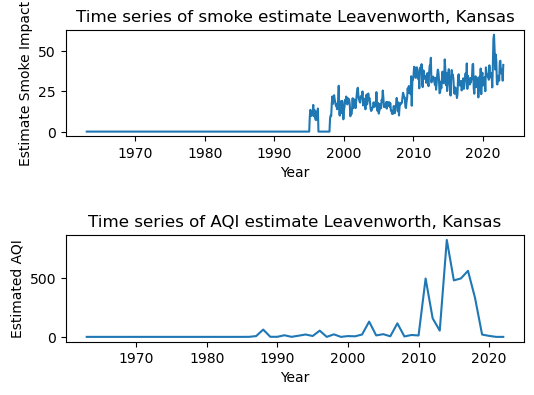

In [343]:
smoke_estimates = []
dates = []
for year in annual_smoke_estimates.keys():
    dates.append("01/01/"+ str(year))
    smoke_estimates.append(annual_smoke_estimates[year]['total_smoke_volume_estimate'])
dates = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]

dates2 = []
aqi_estimates_list = []
for date in aqi_estimates.keys():
    year = date[0:4]
    month = date[4:6]
    day = "01"
    date_str = month + "/" + day + "/" + year
    dates2.append(date_str)
    aqi_estimates_list.append(aqi_estimates[date])
dates2 = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates2]
fig, ax = plt.subplots(2,1)
fig.tight_layout(pad=5.0)
ax[0].plot(dates2, aqi_estimates_list)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Estimate Smoke Impact")
ax[0].set_title("Time series of smoke estimate Leavenworth, Kansas")

ax[1].plot(dates, smoke_estimates)
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Estimated AQI")
ax[1].set_title("Time series of AQI estimate Leavenworth, Kansas")